# 5 Linear Regression Analysis

This notebook performs linear regression analysis on CPU performance data, comparing Simple Linear Regression (SLR), Multiple Linear Regression (MLR), and Recursive Feature Elimination (RFE).

Linear regression is a linear approach to modelling the relationship between a continuous outcome variable and one or more continuous predictors/features. Although this is beyond the scope of this unit, linear regression can be applied to model non-linear relationships as well with clever manipulation of the predictors. The term “linear” only applies to the parameter coefficients, and not the predictors in the model.
Applications of linear regression typically fall into two categories:

(1)	Prediction - model is used to predict the outcome based on some unobserved or untested values of the predictors.
(2)	Association - model estimates is used to explain the strength and nature of the relationship between the outcome and the predictors.

In machine learning, application (1) is the main focus, while (2) is secondary or of little interest.

### 5.1 Install and Import Required Libraries

To start, you need to install and load the relevant packages for this workshop.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

### 5.2 Load and Examine CPU Data

The CPU.csv data file contains performance data relating to computer hardware from various vendors and models. The variables in the files are as follows:

(1)	Vendor name: 27 (adviser, amdahl, apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, dg, formation, four-phase, gould, harris, honeywell, hp, ibm, ipl, magnuson, microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens)

(2)	Model name: many unique symbols

(3)	MYCT: machine cycle time in nanoseconds (integer)

(4)	MMIN: minimum main memory in kilobytes (integer)

(5)	MMAX: maximum main memory in kilobytes (integer)

(6)	CACH: cache memory in kilobytes (integer)

(7)	CHMIN: minimum channels in units (integer)

(8)	CHMAX: maximum channels in units (integer)

(9)	PRP: published relative CPU performance (integer)

The goal here is to predict relative CPU performance based on its cycle time, memory and etc. The vendors’ names and the hardware model, i.e. Variables (1) and (2) are inconsequential in this exercise.


In [2]:
# Read the data
url = "https://raw.githubusercontent.com/asim-cv/MAT6206/refs/heads/main/Datasets/CPU.csv"
CPU = pd.read_csv(url)

print("Data shape:", CPU.shape)
print("\nData types:")
print(CPU.dtypes)
print("\nFirst few rows:")
print(CPU.head())

Data shape: (164, 9)

Data types:
Vendor    object
Model     object
MYCT       int64
MMIN       int64
MMAX       int64
CACH       int64
CHMIN      int64
CHMAX      int64
PRP        int64
dtype: object

First few rows:
    Vendor     Model  MYCT   MMIN   MMAX  CACH  CHMIN  CHMAX  PRP
0  adviser     32/60   125    256   6000   256     16    128  198
1   amdahl   470v/7a    29   8000  32000    32      8     32  220
2   amdahl  580-5840    23  16000  32000    64     16     32  367
3   amdahl  580-5850    23  16000  32000    64     16     32  489
4   amdahl  580-5860    23  16000  64000    64     16     32  636


### 5.3 Create Training and Test Datasets

Given that PRP is the outcome of interest and that it is a numeric variable, linear regression modelling is therefore appropriate here. Not only do we want to build a linear regression model here, we also want to be evaluate the predictions from said model.

Hence, we will now split the dataset into training and test sets. The training set will be used to build the model, and the test set will be used to evaluate its predictive performance. Here, we will use a 75/25 split, i.e. randomly select 75% of the original data to be in the training set, and the remaining 25% form the test set


In [3]:
# Set random seed for reproducibility
np.random.seed(1)

# Split the data into training (75%) and test (25%) sets
trainData, testData = train_test_split(CPU, test_size=0.25, random_state=1)

print(f"Training set size: {len(trainData)}")
print(f"Test set size: {len(testData)}")

Training set size: 123
Test set size: 41


### 5.4 Simple Linear Regression (SLR) - PRP vs MMAX

Simple linear regression refers to the situation where the outcome variable is regressed against one predictor or feature.

Suppose, at this moment, we are only interested in predicting PRP from maximum main memory, i.e. MMAX. Let us examine their relationship via a scatter plot and Person’s correlation coefficient.

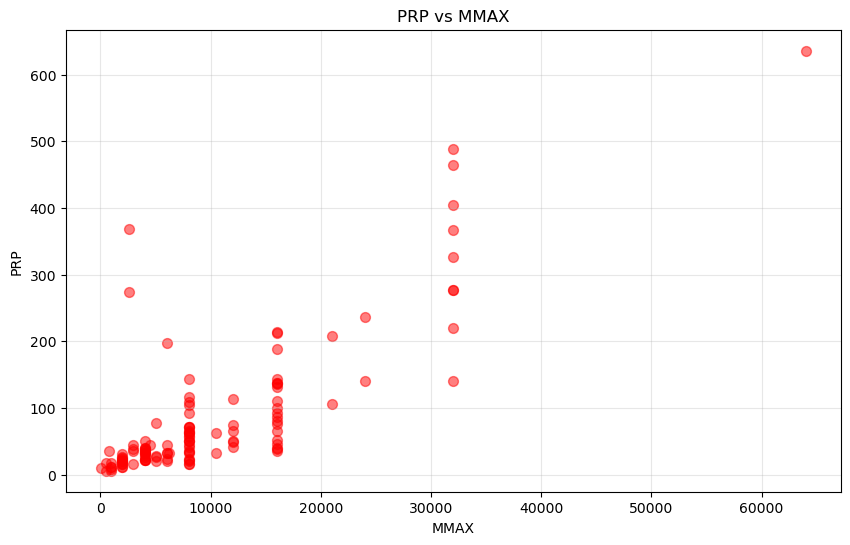

Correlation matrix:
           PRP      MMAX
PRP   1.000000  0.811887
MMAX  0.811887  1.000000


In [4]:
# Extract PRP and MMAX from training data
trainData_slr = trainData[['PRP', 'MMAX']]

# Plot PRP against MMAX
plt.figure(figsize=(10, 6))
plt.scatter(trainData_slr['MMAX'], trainData_slr['PRP'], 
           color='red', alpha=0.5, s=50)
plt.xlabel('MMAX')
plt.ylabel('PRP')
plt.title('PRP vs MMAX')
plt.grid(True, alpha=0.3)
plt.show()

# Pearson's correlation coefficient
correlation = trainData_slr.corr()
print("Correlation matrix:")
print(correlation)

In [5]:
# Fit Simple Linear Regression model
X_slr = trainData_slr[['MMAX']]
y_slr = trainData_slr['PRP']

mod_slr = LinearRegression()
mod_slr.fit(X_slr, y_slr)

# Model summary using statsmodels for detailed statistics
X_slr_sm = sm.add_constant(X_slr)
mod_slr_sm = sm.OLS(y_slr, X_slr_sm).fit()

print("Simple Linear Regression Summary:")
print(mod_slr_sm.summary())

# Show estimated coefficients
print(f"\nIntercept: {mod_slr.intercept_:.3f}")
print(f"MMAX coefficient: {mod_slr.coef_[0]:.3f}")

Simple Linear Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    PRP   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     234.0
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           4.65e-30
Time:                        04:55:14   Log-Likelihood:                -683.63
No. Observations:                 123   AIC:                             1371.
Df Residuals:                     121   BIC:                             1377.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9

We will now evaluate the predictive performance of this model on the test data and determine the prediction root mean squared error (RMSE) and bias, and the correlation and predicted R2 between the actual and predicted PRP values for the test set. Prediction RMSE and bias that are close to zero, and a correlation value that is close to one are desired.

In [6]:
# Predict PRP with test data
X_test_slr = testData[['MMAX']]
pred_slr = mod_slr.predict(X_test_slr)

# Calculate performance metrics
diff_slr = testData['PRP'] - pred_slr
RMSE_slr = np.sqrt(mean_squared_error(testData['PRP'], pred_slr))
bias_slr = np.mean(diff_slr)
cor_slr = np.corrcoef(testData['PRP'], pred_slr)[0, 1]
predR2_slr = cor_slr**2

# Show results for SLR
SLR_pf = {
    'RMSE': RMSE_slr,
    'Bias': bias_slr,
    'Corr': cor_slr,
    'PredR2': predR2_slr
}

print("Simple Linear Regression Performance:")
for metric, value in SLR_pf.items():
    print(f"{metric}: {value:.3f}")

Simple Linear Regression Performance:
RMSE: 107.529
Bias: 2.382
Corr: 0.869
PredR2: 0.755


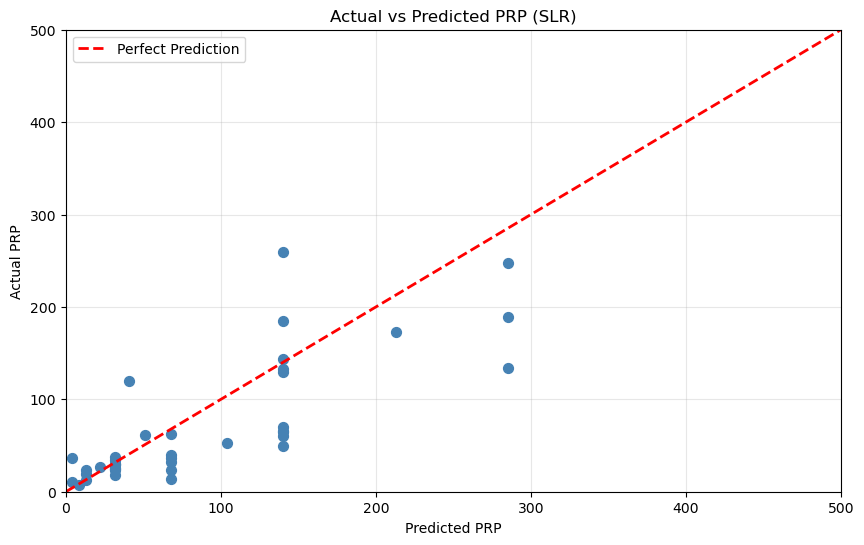

In [7]:
# Plot actual vs predicted for SLR
plt.figure(figsize=(10, 6))
plt.scatter(pred_slr, testData['PRP'], color='steelblue', s=50)
plt.plot([0, 500], [0, 500], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Predicted PRP')
plt.ylabel('Actual PRP')
plt.title('Actual vs Predicted PRP (SLR)')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### 5.5 Multiple Linear Regression (MLR)

In MLR, the continuous outcome is linearly modelled as a function of two or more continuous predictors or features.

We will revisit the CPU data, but this time we will consider all six predictors, i.e. Columns 3 to 8. 

First, we will generate a scatter plot matrix between all the predictors and the outcome PRP.


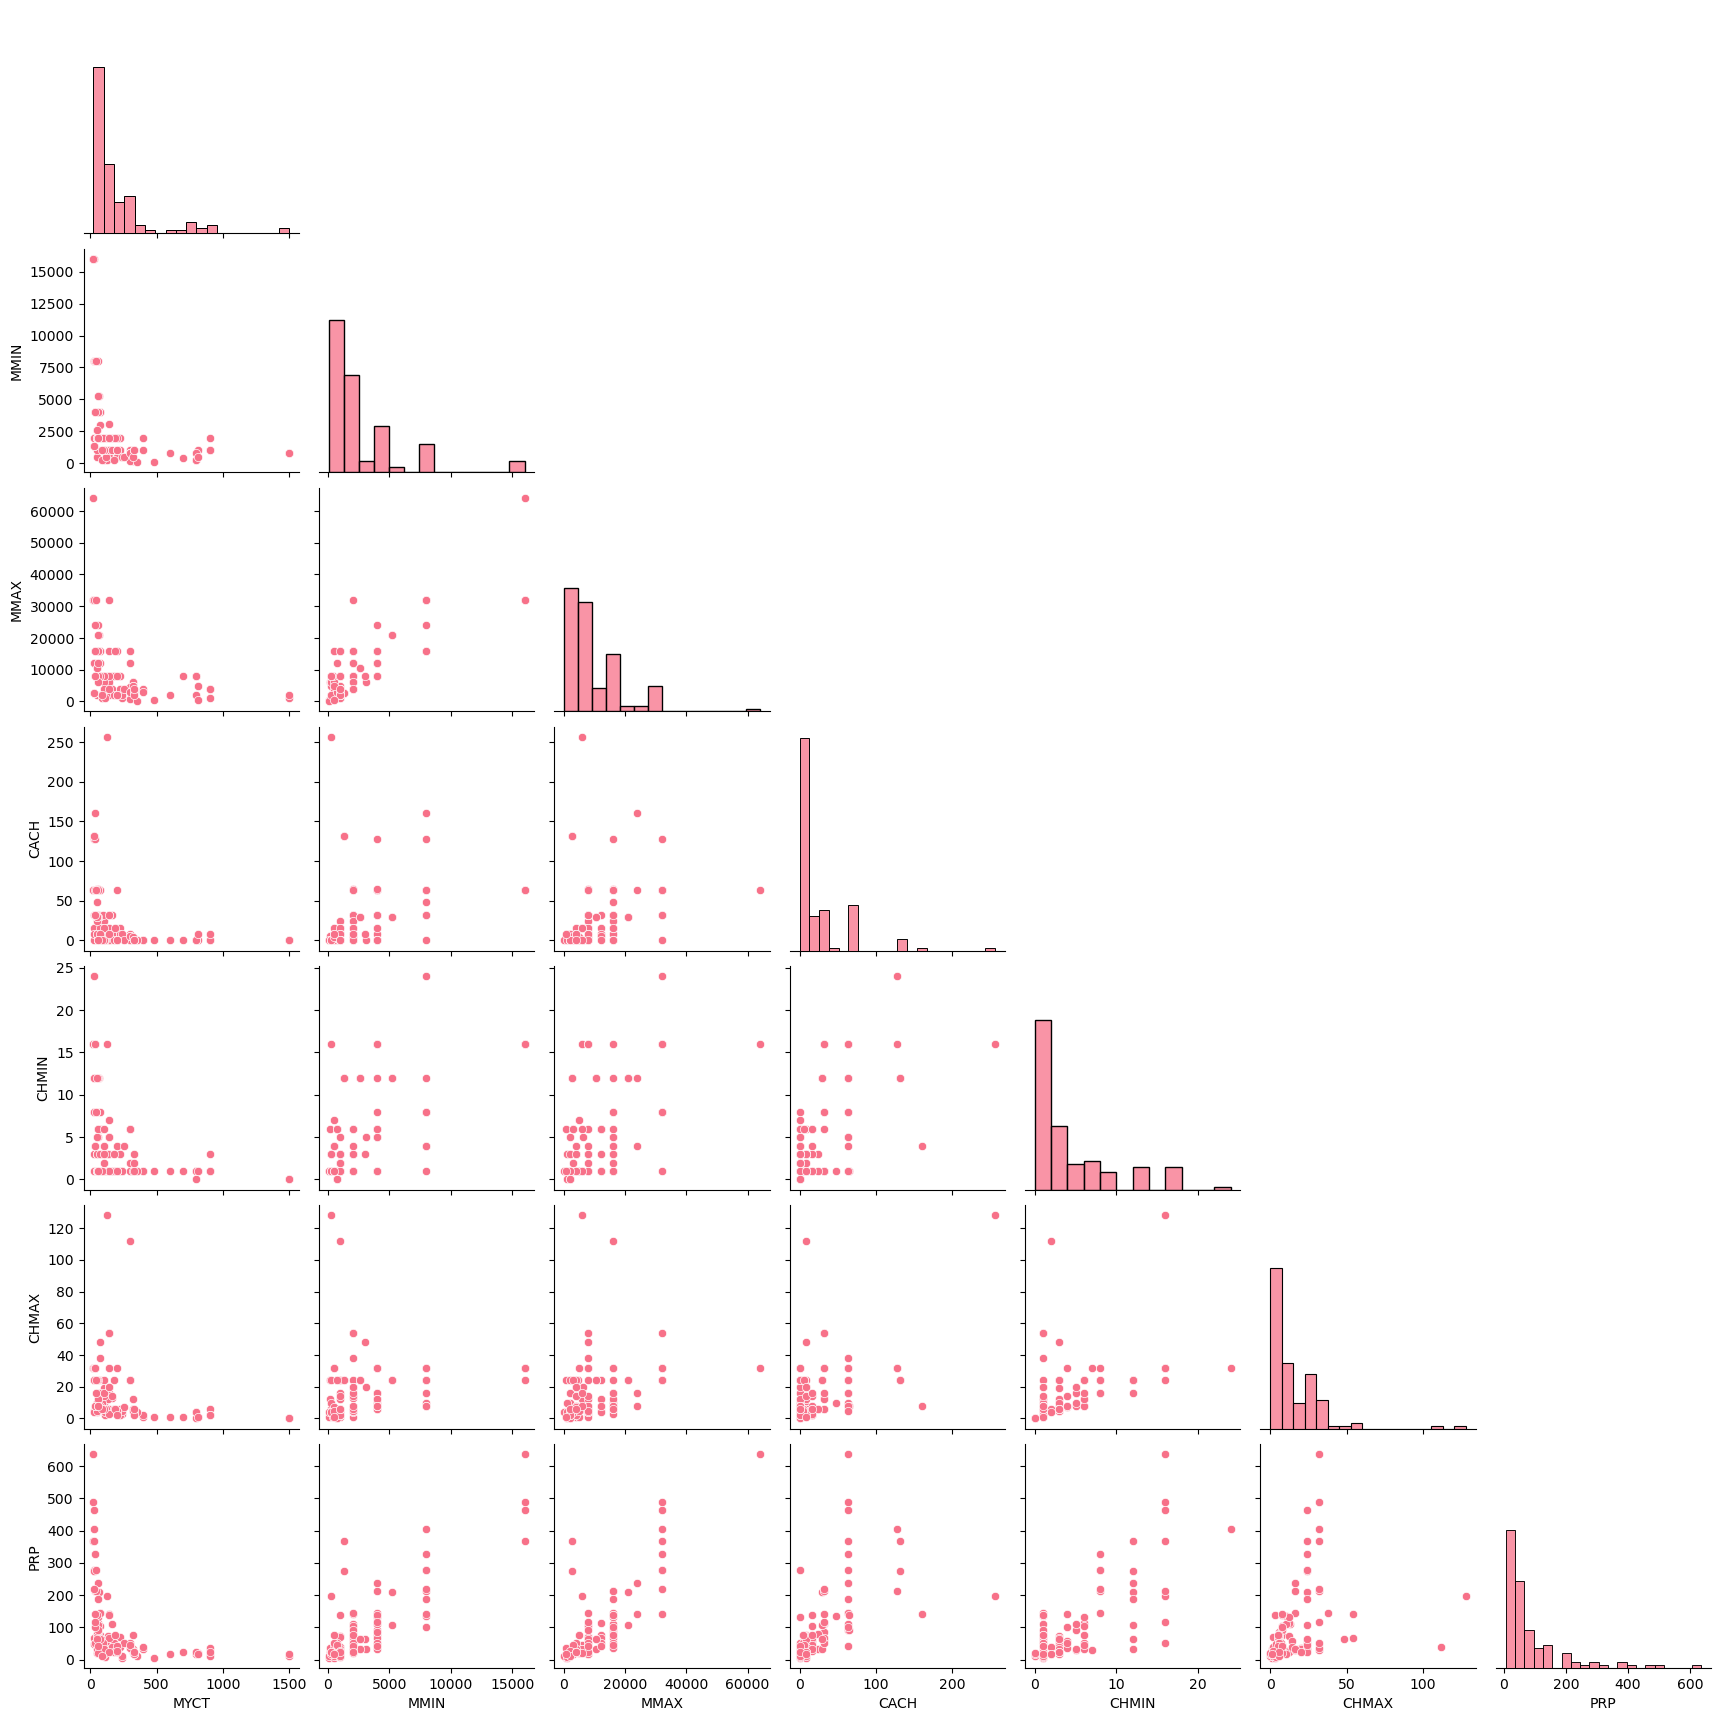

In [8]:
# Create pairplot for numerical variables (lower triangle only)
numerical_cols = trainData.select_dtypes(include=[np.number]).columns
# Use corner=True to explicitly show only lower triangle
sns.pairplot(trainData[numerical_cols], diag_kind='hist', corner=True)
plt.show()


The last row of the scatter plot matrix shows the bivariate relationship between PRP with each of the 6 features. It is clear from the 1st scatter plot along this row that PRP is not linearly correlated with MYCT and that transforming the data may be useful here. In fact, the two are actually log-linearly related, but let’s not worry about this. If we leave MYCT as is in the MLR model, then it is likely that the final result will shown that MYCT is not a significant predictor of PRP. However, it may not be wise to conclude which variables are NOT important based solely on these plots. In particular for variables with uninteresting pattern that sometimes they can help explain certain aspects of the outcome variable that the visually important variables may not.

With the scatter plot matrix, it is also important to observe the relationship between the features, and in particular, those that are highly correlated with each other as this can imply collinearity in our data. We can dig deeper by examining the correlation matrix between the features.


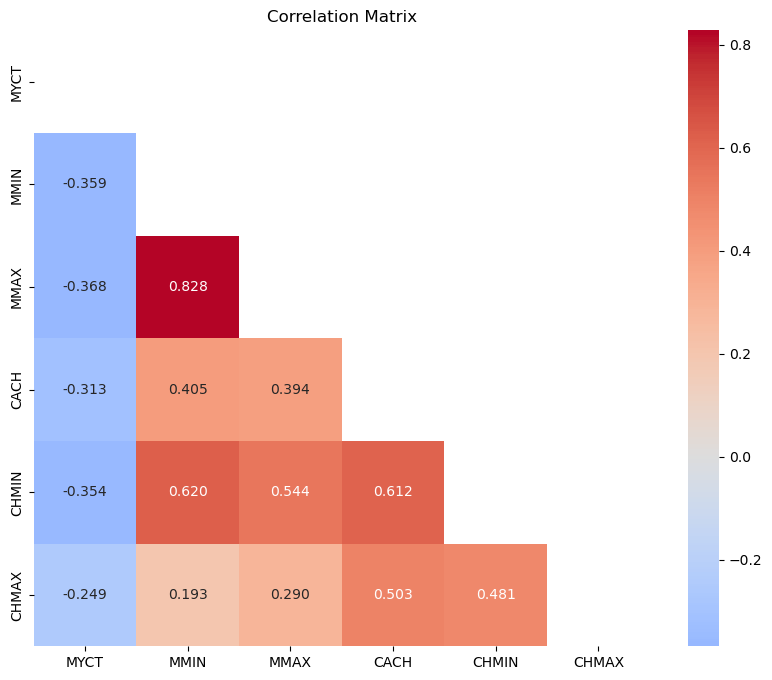

In [15]:
# Correlation matrix heatmap (excluding PRP column)
plt.figure(figsize=(10, 8))
# Select only predictor variables (exclude PRP)
predictor_cols = trainData[numerical_cols].drop('PRP', axis=1)
correlation_matrix = predictor_cols.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

### 5.6 Building MLR Model

Let us go ahead and build the multiple regression model and regress PRP against the 6 features.

In [16]:
# Prepare features for MLR (excluding non-numeric columns)
feature_cols = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
X_mlr = trainData[feature_cols]
y_mlr = trainData['PRP']

# Fit Multiple Linear Regression model
mod_mlr = LinearRegression()
mod_mlr.fit(X_mlr, y_mlr)

# Model summary using statsmodels
X_mlr_sm = sm.add_constant(X_mlr)
mod_mlr_sm = sm.OLS(y_mlr, X_mlr_sm).fit()

print("Multiple Linear Regression Summary:")
print(mod_mlr_sm.summary())

# Show estimated coefficients
print(f"\nIntercept: {mod_mlr.intercept_:.3f}")
for i, feature in enumerate(feature_cols):
    print(f"{feature} coefficient: {mod_mlr.coef_[i]:.3f}")

Multiple Linear Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    PRP   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     107.7
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           4.82e-45
Time:                        05:10:09   Log-Likelihood:                -634.04
No. Observations:                 123   AIC:                             1282.
Df Residuals:                     116   BIC:                             1302.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20

The variance inflation factor (VIF) can be generated. Is there any evidence of collinearity based on the VIF measure?

In [28]:
# Calculate VIF for multicollinearity check
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_results = calculate_vif(X_mlr)
print("Variance Inflation Factors:")
print(vif_results)

Variance Inflation Factors:
  Variable       VIF
0     MYCT  1.100441
1     MMIN  6.785834
2     MMAX  6.550790
3     CACH  2.464423
4    CHMIN  4.202830
5    CHMAX  2.474008


### 5.7 Evaluating the MLR Model

We will now evaluate the predictive performance of the MLR model.

In [17]:
# Predict PRP with test data
X_test_mlr = testData[feature_cols]
pred_mlr = mod_mlr.predict(X_test_mlr)

# Calculate performance metrics
diff_mlr = testData['PRP'] - pred_mlr
RMSE_mlr = np.sqrt(mean_squared_error(testData['PRP'], pred_mlr))
bias_mlr = np.mean(diff_mlr)
cor_mlr = np.corrcoef(testData['PRP'], pred_mlr)[0, 1]
predR2_mlr = cor_mlr**2

# Predictive measures for MLR
MLR_pf = {
    'RMSE': RMSE_mlr,
    'Bias': bias_mlr,
    'Corr': cor_mlr,
    'PredR2': predR2_mlr
}

print("Multiple Linear Regression Performance:")
for metric, value in MLR_pf.items():
    print(f"{metric}: {value:.3f}")

Multiple Linear Regression Performance:
RMSE: 58.281
Bias: 8.111
Corr: 0.968
PredR2: 0.938


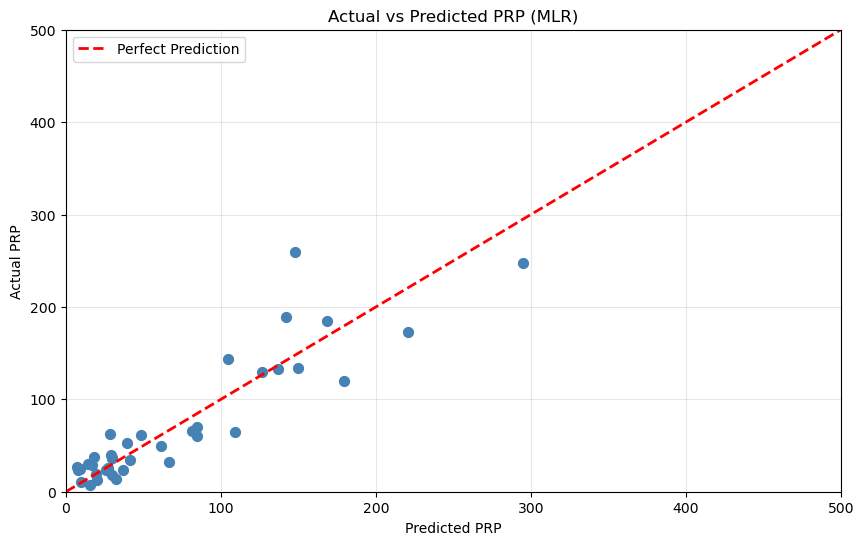

In [18]:
# Plot actual vs predicted for MLR
plt.figure(figsize=(10, 6))
plt.scatter(pred_mlr, testData['PRP'], color='steelblue', s=50)
plt.plot([0, 500], [0, 500], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Predicted PRP')
plt.ylabel('Actual PRP')
plt.title('Actual vs Predicted PRP (MLR)')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [19]:
# Compare SLR and MLR results
comparison_df = pd.DataFrame({
    'SLR': list(SLR_pf.values()),
    'MLR': list(MLR_pf.values())
}, index=list(SLR_pf.keys()))

print("Model Comparison:")
print(comparison_df.round(3))

Model Comparison:
            SLR     MLR
RMSE    107.529  58.281
Bias      2.382   8.111
Corr      0.869   0.968
PredR2    0.755   0.938


### 5.9 Recursive Feature Elimination (RFE)

There are a number of ways to overcome or alleviate this problem, including performing the log-likelihood test, stepwise regression or other variable selection methods. Here we will perform a recursive feature elimination (RFE). The RFE, a backward variable selection process, is as follows:

Step 1: Build a model to all features in the training set and rank each feature based on its importance to the model. In our case, it is the p-value.

Step 2: Keeping priority to the most important variables, iterate through by building models of given subset sizes, that is, subsets of most important predictors determined from step 1. Ranking of the features is recalculated in each iteration.

Step 3: The model performances are compared across different subset sizes to arrive at the optimal number and list of final predictors.


In [33]:
# Recursive Feature Elimination (RFE) with Cross Validation
from random import shuffle
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(1)

# Define the subsets of features to test (equivalent to R's subsets <- c(2:6))
subsets = list(range(2, 7))  # [2, 3, 4, 5, 6] features

print("Testing feature subsets:", subsets)

# Perform RFE with cross-validation (equivalent to R's rfeControl with repeatedcv)
estimator = LinearRegression()
cv = KFold(n_splits=10,shuffle=True,random_state=1)

rfe_cv = RFECV(estimator=estimator, 
               step=1,  # Remove one feature at a time
               cv=cv,   # 10-fold cross validation
               scoring='neg_mean_squared_error',  # Use MSE as scoring metric
               min_features_to_select=2)  # Minimum 2 features

# Fit RFE with features only (columns 3-8, excluding PRP)
feature_cols = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
X_rfe = trainData[feature_cols]
y_rfe = trainData['PRP']

rfe_cv.fit(X_rfe, y_rfe)

print("RFE Results:")
print(f"Optimal number of features: {rfe_cv.n_features_}")
print(f"Selected features: {[feature_cols[i] for i in range(len(feature_cols)) if rfe_cv.support_[i]]}")
print(f"Feature rankings: {dict(zip(feature_cols, rfe_cv.ranking_))}")
print(f"Cross-validation scores: {rfe_cv.cv_results_['mean_test_score']}")


Testing feature subsets: [2, 3, 4, 5, 6]
RFE Results:
Optimal number of features: 6
Selected features: ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
Feature rankings: {'MYCT': 1, 'MMIN': 1, 'MMAX': 1, 'CACH': 1, 'CHMIN': 1, 'CHMAX': 1}
Cross-validation scores: [-5627.43107187 -4957.87346611 -2744.07635395 -2775.77735973
 -2233.57452942]


In this instance, the RFE algorithm suggests that all 6 features should be retained from a prediction accuracy standpoint, even though, statistically speaking, both CHMAX and MYCT are non-significant predictors.

Note that at the end of the RFE process, only the optimal model is stored, and as one of the components (called fit) in a list.


In [26]:
# Access the optimal model and show its coefficients
optimal_model = rfe_cv.estimator_

print("Optimal Model Coefficients:")
print(f"Intercept: {optimal_model.intercept_:.3f}")

selected_features = [feature_cols[i] for i in range(len(feature_cols)) if rfe_cv.support_[i]]
for i, feature in enumerate(selected_features):
    print(f"{feature}: {optimal_model.coef_[i]:.3f}")

# Model summary using statsmodels
X_optimal = X_rfe.iloc[:, rfe_cv.support_]
X_optimal_sm = sm.add_constant(X_optimal)
optimal_model_sm = sm.OLS(y_rfe, X_optimal_sm).fit()

print("\nOptimal Model Summary:")
print(optimal_model_sm.summary())


Optimal Model Coefficients:
Intercept: -20.282
MYCT: 0.018
MMIN: 0.011
MMAX: 0.004
CACH: 0.675
CHMIN: 5.399
CHMAX: -0.237

Optimal Model Summary:
                            OLS Regression Results                            
Dep. Variable:                    PRP   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     107.7
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           4.82e-45
Time:                        05:36:28   Log-Likelihood:                -634.04
No. Observations:                 123   AIC:                             1282.
Df Residuals:                     116   BIC:                             1302.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.0

To apply the optimal model and predict on the test set, we can use the predict(.) function as per usual.

In [37]:
# Predict on the test set using the optimal model
X_test_optimal = testData[selected_features]
pred_optimal = optimal_model.predict(X_test_optimal)

#print("Predictions (first 10):")
#print(pred_optimal[:10].round(3))


In [28]:
# Calculate performance metrics for RFE model
diff_rfe = testData['PRP'] - pred_optimal
RMSE_rfe = np.sqrt(mean_squared_error(testData['PRP'], pred_optimal))
bias_rfe = np.mean(diff_rfe)
cor_rfe = np.corrcoef(testData['PRP'], pred_optimal)[0, 1]
predR2_rfe = cor_rfe**2

# Show results for RFE
RFE_pf = {
    'RMSE': RMSE_rfe,
    'Bias': bias_rfe,
    'Corr': cor_rfe,
    'PredR2': predR2_rfe
}

print("RFE Model Performance:")
for metric, value in RFE_pf.items():
    print(f"{metric}: {value:.3f}")


RFE Model Performance:
RMSE: 58.281
Bias: 8.111
Corr: 0.968
PredR2: 0.938


In [29]:
# 10-Fold Cross Validation Comparison
from sklearn.model_selection import cross_val_score, RepeatedKFold

# Set up 10-fold repeated cross validation (equivalent to R's repeatedcv with repeats=10)
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

# Cross validation for SLR
slr_cv_scores = cross_val_score(mod_slr, X_slr, y_slr, 
                               cv=rkf, scoring='neg_mean_squared_error')
slr_cv_rmse = np.sqrt(-slr_cv_scores)

# Cross validation for MLR
mlr_cv_scores = cross_val_score(mod_mlr, X_mlr, y_mlr, 
                               cv=rkf, scoring='neg_mean_squared_error')
mlr_cv_rmse = np.sqrt(-mlr_cv_scores)

# Cross validation for RFE optimal model
rfe_cv_scores = cross_val_score(optimal_model, X_optimal, y_rfe, 
                               cv=rkf, scoring='neg_mean_squared_error')
rfe_cv_rmse = np.sqrt(-rfe_cv_scores)

print("10-Fold Cross Validation Results (RMSE):")
print(f"SLR: {slr_cv_rmse.mean():.3f} ± {slr_cv_rmse.std():.3f}")
print(f"MLR: {mlr_cv_rmse.mean():.3f} ± {mlr_cv_rmse.std():.3f}")
print(f"RFE: {rfe_cv_rmse.mean():.3f} ± {rfe_cv_rmse.std():.3f}")


10-Fold Cross Validation Results (RMSE):
SLR: 58.828 ± 26.143
MLR: 45.359 ± 18.015
RFE: 45.359 ± 18.015


In [30]:
# Final Model Comparison - All Models
final_comparison = pd.DataFrame({
    'SLR': list(SLR_pf.values()),
    'MLR': list(MLR_pf.values()),
    'RFE': list(RFE_pf.values())
}, index=list(SLR_pf.keys()))

print("Final Model Comparison:")
print(final_comparison.round(3))

# Add cross-validation results
cv_comparison = pd.DataFrame({
    'SLR_CV': [slr_cv_rmse.mean(), slr_cv_rmse.std()],
    'MLR_CV': [mlr_cv_rmse.mean(), mlr_cv_rmse.std()],
    'RFE_CV': [rfe_cv_rmse.mean(), rfe_cv_rmse.std()]
}, index=['CV_RMSE_Mean', 'CV_RMSE_Std'])

print("\nCross-Validation Results:")
print(cv_comparison.round(3))


Final Model Comparison:
            SLR     MLR     RFE
RMSE    107.529  58.281  58.281
Bias      2.382   8.111   8.111
Corr      0.869   0.968   0.968
PredR2    0.755   0.938   0.938

Cross-Validation Results:
              SLR_CV  MLR_CV  RFE_CV
CV_RMSE_Mean  58.828  45.359  45.359
CV_RMSE_Std   26.143  18.015  18.015


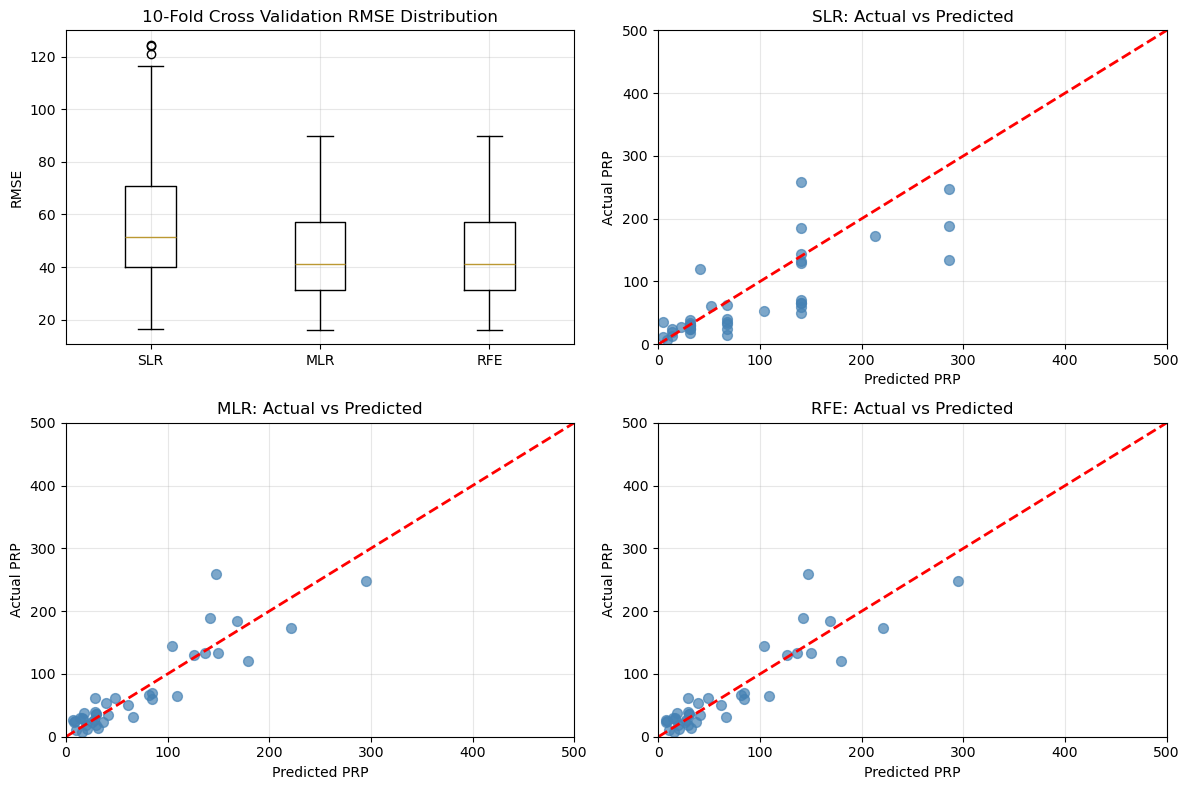

In [32]:
# Visualization: Cross-Validation Results Box Plot
plt.figure(figsize=(12, 8))

# Create subplot for cross-validation results
plt.subplot(2, 2, 1)
cv_data = [slr_cv_rmse, mlr_cv_rmse, rfe_cv_rmse]
plt.boxplot(cv_data, labels=['SLR', 'MLR', 'RFE'])
plt.title('10-Fold Cross Validation RMSE Distribution')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)

# Actual vs Predicted plots for all models
plt.subplot(2, 2, 2)
plt.scatter(pred_slr, testData['PRP'], color='steelblue', s=50, alpha=0.7)
plt.plot([0, 500], [0, 500], 'r--', linewidth=2)
plt.xlabel('Predicted PRP')
plt.ylabel('Actual PRP')
plt.title('SLR: Actual vs Predicted')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.scatter(pred_mlr, testData['PRP'], color='steelblue', s=50, alpha=0.7)
plt.plot([0, 500], [0, 500], 'r--', linewidth=2)
plt.xlabel('Predicted PRP')
plt.ylabel('Actual PRP')
plt.title('MLR: Actual vs Predicted')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(pred_optimal, testData['PRP'], color='steelblue', s=50, alpha=0.7)
plt.plot([0, 500], [0, 500], 'r--', linewidth=2)
plt.xlabel('Predicted PRP')
plt.ylabel('Actual PRP')
plt.title('RFE: Actual vs Predicted')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
